<a href="https://colab.research.google.com/github/sinaabbasi1/machine-learning-and-deep-learning/blob/main/Assignments/Assignment%2003/ML_Assignment_03_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statistics

Configuring the device:

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In this homework, we will explore deep networks using  PyTorch framework!
With the MNIST dataset consisting of 70000 images (28 * 28 * 1) of handwritten digits, we will train a multiple-layer perceptron network to detect the digit corresponding to the input image.

#Data Loading

Run the cell below to download the dataset.

In [ ]:

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(root='./data', train=False, download=True,transform=transforms.ToTensor())


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
mnist_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
mnist_test

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [ ]:
image, label = mnist_test[0]
label

7

In [ ]:
image.shape

torch.Size([1, 28, 28])

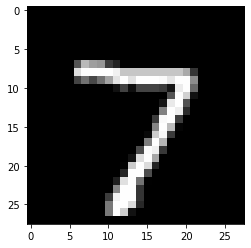

In [ ]:
plt.imshow(image.reshape(28,28), cmap='gray')

#Model


The model we want to classify the MNIST dataset is a two-hidden-layer MLP with 120 and 84 units in each layer, respectively.

Create a PyTorch model for described model and use ReLU for the activation function.




In [ ]:
class MultilayerPerceptron(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) #10 classes

    def forward (self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [ ]:
torch.manual_seed(80)
model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Answer these questions:
2. Denote the size of the weights matrix of each layer (consider the input and output layer as well).
1. What initial values are used  ​​for the weights and biases of your model? (Do not report the specific value, we are interested in distributions that are used.)

2. As shown below we have:



    

> *   120 * 784
> *   84 * 120
> *   10 * 84

if we consider bias vectors as weights too, then we have vectors   of size:

> *   120
> *   84
> *   10

In [ ]:
for name, param in model.named_parameters():
    print(f"Parameter {name}, shape {param.shape}")

Parameter fc1.weight, shape torch.Size([120, 784])
Parameter fc1.bias, shape torch.Size([120])
Parameter fc2.weight, shape torch.Size([84, 120])
Parameter fc2.bias, shape torch.Size([84])
Parameter fc3.weight, shape torch.Size([10, 84])
Parameter fc3.bias, shape torch.Size([10])


3. Linear layers are initialized with stdv = 1 / math.sqrt(number of inputs) and the distribution of uniform(-stdv, stdv)

#Training


In this section, we want to train our MLP model using the SGD algorithm.

As we discussed in class, instead of calculating loss using the whole inputs, we break the dataset (with size $n$) into some batches of size m ($m < n$) and, at each iteration, calculate the loss of one batch and update the weights.  

Using the `DataLoader` class of the torch library, complete the cell below to batch the test and train dataset.

In [ ]:
batch_size = 100
train_loader = DataLoader(dataset=mnist_train, batch_size=100, shuffle=True) # shuffle for avoiding overfitting
test_loader = DataLoader(dataset=mnist_test, batch_size=100, shuffle=False)

there are yet a couple of hyperprameters that we should define before training.

In [ ]:
epochs = 10
learning_rate = 0.01 #feel free to play with this

Answer these questions:
* Prove that the **expected value** of the gradient obtained using a random batch equals the gradient of the whole dataset.


The same way you show that the mean of any simple random sample is an unbiased estimator of the population mean: linearity of expectation.

Linearity of expectation just means that $E[X+Y] = E[X]+E[Y]$

We have that

$J(X) = \frac{1}{n} \sum^n_{i=1} Loss(f(x_i),y_i)$

Differentiate both sides and use the linearity of differentiation to move the ∇ inside the summation

$\nabla J(X) = \frac{1}{n} \sum^n_{i=1} \nabla Loss(f(x_i),y_i)$

We want to evaluate

$E_A[ \frac{1}{m} \sum^m_{i=1} \nabla Loss(f(x_i),y_i) ]$

Apply linearity of expectation

$=\frac{1}{m} \sum^m_{I=1} E_A[\nabla Loss(f(x_i),y_i)]$


What's $E_A[\nabla Loss(f(x_i),y_i)]$ ?

$E[X]=\sum_{x} x*P(X=x)$

Since the examples are chosen uniformly at random, all their probabilities $(P(X=x))$ are equal to $\frac{1}{n}$, so it's just the average value of the gradient over all examples.

Mathematically, that's:

$E_A[\nabla Loss(f(x_i),y_i)] = \sum^n_{j=1} P(i=j)* \nabla Loss(f(x_j),y_j)$

Where $P(i=j)=\frac{1}{n}$, so

$E_A[\nabla Loss(f(x_i),y_i)] = \frac{1}{n} \sum^n_{j=1} \nabla Loss(f(x_j),y_j) = \nabla J(X)$

Plugging that back in to

$E_A[ \frac{1}{m} \sum^m_{I=1} \nabla Loss(f(x_i),y_i) ] = \frac{1}{m} \sum^m_{i=1} E_A[\nabla Loss(f(x_i),y_i)]$

We get

$E_A[ \frac{1}{m} \sum^m_{i=1} \nabla Loss(f(x_i),y_i) ]$

$=\frac{1}{m} \sum^m_{i=1} \nabla J(X)$

$= \nabla J(X)$

* For the dataset of size $n = $12000, if the batch size is 200, what would be the number of weight updates (or iterations) in a total of 5 epoche?

${\frac{12000}{200}} = 60$     iterations per epoch

as we have 5 epochs, so $60 \times 5 = 300$

So, we have 300 iterations (weight updates)


Complete the training function below, such that at each epoch:




1. For each batch:

  1. Perform feedforward
  2. Calculate loss (use cross-entropy loss)
  3. Perform backpropagation and updating weights

2. Calculate and report the training accuracy and loss for each epoch (use the average of the batch accuracy as epoch accuracy).
3. Calculate and report the test accuracy and loss for each epoch


In [ ]:
#initialize loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
model.to(device)

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Highly encourage you to use [this](https://github.com/tqdm/tqdm) awesome package called taqaddum to have a nice progress bar for the training process


In [ ]:
def eval_model(model1, data_loader, test_losses, test_acc):
    model1.eval() # Set model to eval mode

    correct_test = 0
    loss_test = 0

    with torch.no_grad(): # Deactivate gradients for the following code
        for batch_test in data_loader:

            images_test = batch_test[0].reshape(-1, 28*28).to(device)
            labels_test = batch_test[1].to(device)

            preds_test = model1(images_test)
            preds_test = preds_test.squeeze(dim=1)

            # Loss of each epoch
            loss_test += loss_function(preds_test.squeeze(-1), labels_test)

            # Accuracy of each epoch
            _, predicted_test = torch.max(preds_test, 1)
            correct_test += (predicted_test == labels_test).sum().item()

        test_losses.append(loss_test.item() / len(data_loader))
        accuracy_test = (correct_test / 10000) * 100
        test_acc.append(accuracy_test)

    return test_losses, test_acc

In [ ]:
def train(model, loss_function, optimizer, train_loader, test_loader, epochs):

    train_losses = []
    test_losses = []
    train_acc = []
    test_acc  = []

    # Set the model to train mode
    model.train()

    # Training loop
    epochs = tqdm(range(epochs))

    for epoch in epochs:

        batch_train_losses = []
        batch_train_acc = []

        model.train()
        for batch in train_loader:

            correct = 0 # Correct prediction per batch

            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            images = batch[0].reshape(-1, 28*28).to(device)
            labels = batch[1].to(device)

            ## Step 2: Run the model on the input data
            preds = model(images)
            preds = preds.squeeze(-1)

            ## Step 3: Calculate the loss
            loss = loss_function(preds, labels)

            ## Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()

            # Perform backpropagation
            loss.backward()

            ## Step 5: Update the parameters
            optimizer.step()

            # Train loss of each batch
            batch_train_losses.append(loss.item())

            # Train accuracy of each batch
            _, predicted = torch.max(preds, 1)
            correct += (predicted == labels).sum().item()
            accuracy = (correct / batch_size) * 100
            batch_train_acc.append(accuracy)

        # Computing test accuracy and test loss for each epoch
        test_losses, test_acc = eval_model(model, test_loader, test_losses, test_acc)

        # Computing train accuracy and train loss for each epoch
        train_losses.append(np.mean(batch_train_losses))
        train_acc.append(np.mean(batch_train_acc))
        epochs.set_postfix({'loss': train_losses})


    return train_losses, train_acc, test_acc, test_losses

In [ ]:
train_losses, train_acc, test_acc, test_losses = train(model, loss_function, optimizer, train_loader, test_loader, epochs)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
print(train_losses)
print(train_acc)
print(test_losses)
print(test_acc)

[2.099452428619067, 0.9876694509387016, 0.5380027292172114, 0.42367590638498465, 0.3749781731516123, 0.34671526789665225, 0.32689036667346955, 0.3108396842579047, 0.2977002102136612, 0.28572378493845463]
[42.02166666666667, 75.85833333333333, 85.675, 88.31333333333333, 89.41833333333334, 90.08666666666667, 90.62666666666667, 91.07, 91.49333333333334, 91.785]
[1.599240264892578, 0.633338623046875, 0.4457451629638672, 0.3774478530883789, 0.34471229553222654, 0.3227128219604492, 0.30660261154174806, 0.29272851943969724, 0.28254343032836915, 0.27272117614746094]
[63.4, 83.78, 87.99, 89.27000000000001, 89.98, 90.63, 91.05, 91.66, 91.86999999999999, 92.19000000000001]


Now plot the training results (one plot for test and training accuracy and one for the loss)

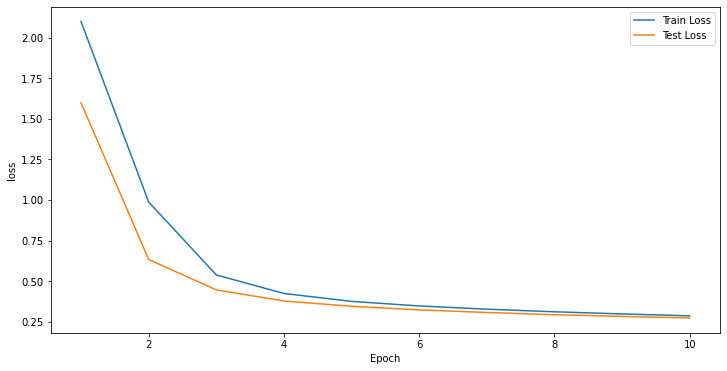

In [ ]:
#plot loss

fig = plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, 11, 1), train_losses, label='Train Loss')
plt.plot(np.arange(1, 11, 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()

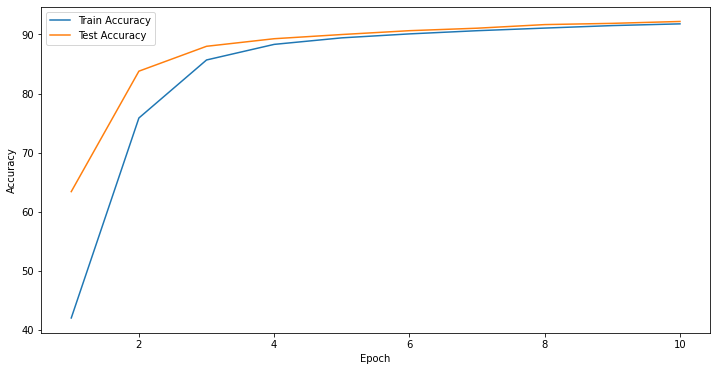

In [ ]:
#plot accuracy

fig = plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, 11, 1), train_acc, label='Train Accuracy')
plt.plot(np.arange(1, 11, 1), test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

Based on your plots, answer these questions:
1. Compare the training and test loss


> As we proceed and the number of epochs grows, the accuracy increases and the loss decreases. We can see that after 5 epochs the training and test loss become really close.


2. Did your model become overfitted? Why?

> No. Because the model works on test data almost as good as training data. Maybe another reason is our model isn't complex, because we only used two layers.

3. Why your training loss is not a  decreasing function with respect to #epoch?

> This is the time that we could use early stopping. because after 5 epochs there is not much things to learn and there is the danger of overfitting.

Repeat the training process for 5 diffrent learning rate and compare the results.

In [ ]:
learning_rates = [0.02, 0.05, 0.1, 0.2, 0.5]
loss_function = nn.CrossEntropyLoss()
alls = {}

for learning_rate in learning_rates:
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    train_losses, train_acc, test_acc, test_losses = train(model, loss_function, optimizer, train_loader, test_loader, epochs)
    alls[learning_rate] = {'train_losses': train_losses, 'train_acc': train_acc, 'test_acc': test_acc, 'test_losses': test_losses}

print(alls)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

{0.02: {'train_losses': [0.27338081513841944, 0.2546092819919189, 0.23759378342578807, 0.22182705125461022, 0.20719591672221818, 0.19375902803614736, 0.18220969588806232, 0.17127310544252394, 0.161995625110964, 0.15362734618907173], 'train_acc': [92.10833333333333, 92.72, 93.19833333333334, 93.66, 94.08333333333333, 94.5, 94.815, 95.12666666666667, 95.40333333333334, 95.65], 'test_acc': [92.65, 93.27, 93.57, 94.19, 94.35, 94.6, 94.72, 94.98, 95.35, 95.39999999999999], 'test_losses': [0.25805728912353515, 0.2406964683532715, 0.22687379837036134, 0.21216659545898436, 0.19983650207519532, 0.1889336395263672, 0.1807798385620117, 0.17137290954589843, 0.16441679000854492, 0.15512752532958984]}, 0.05: {'train_losses': [0.14796017174919446, 0.1309924781601876, 0.11787314724487563, 0.10593712968130907, 0.09500696645739178, 0.08723115600335102, 0.07957295284296076, 0.07377446424216032, 0.06812038459659865, 0.06259223976172507], 'train_acc': [95.77333333333333, 96.295, 96.61333333333333, 96.90333

In [ ]:
print(alls[0.02]['train_losses'])

[0.27338081513841944, 0.2546092819919189, 0.23759378342578807, 0.22182705125461022, 0.20719591672221818, 0.19375902803614736, 0.18220969588806232, 0.17127310544252394, 0.161995625110964, 0.15362734618907173]


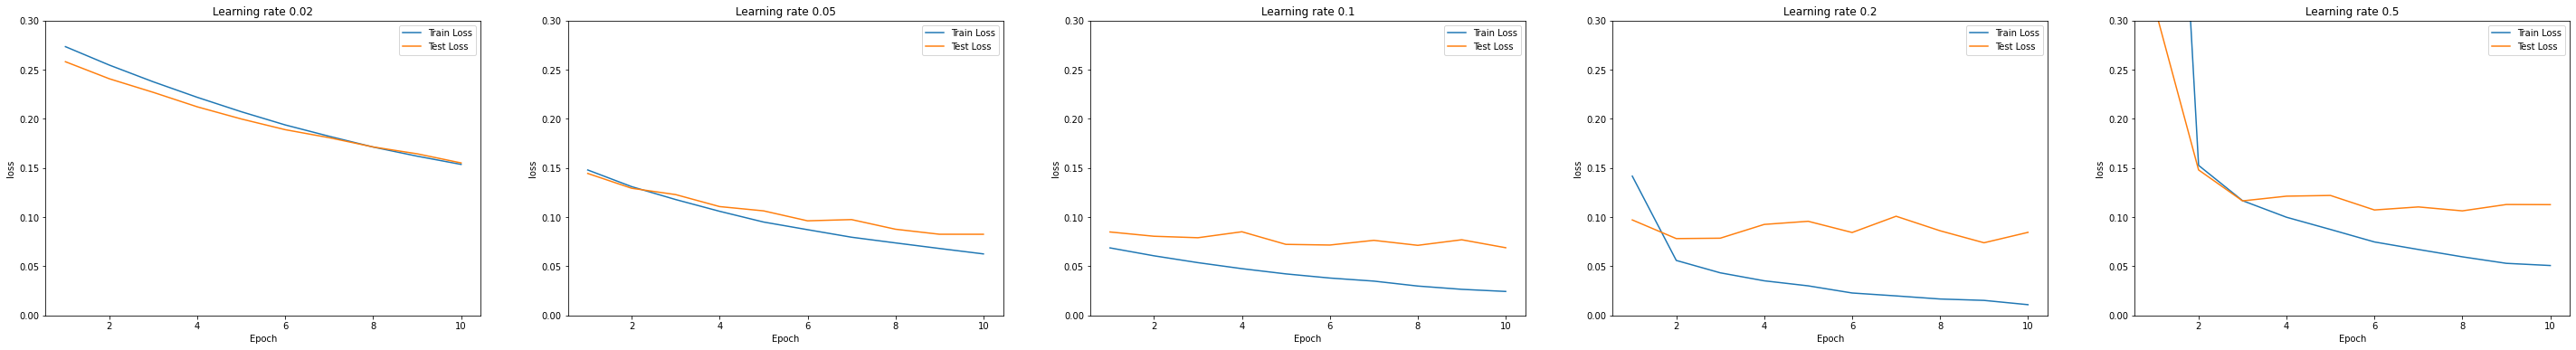

In [ ]:
#plot loss

i = 1
fig = plt.figure(figsize=(50, 6))
for learning_rate in alls:
    plt.subplot(1, 5, i)
    plt.plot(np.arange(1, 11, 1), alls[learning_rate]['train_losses'], label='Train Loss')
    plt.plot(np.arange(1, 11, 1), alls[learning_rate]['test_losses'], label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.ylim([0, 0.3])
    plt.title(f'Learning rate {learning_rate}')
    plt.legend()
    i += 1

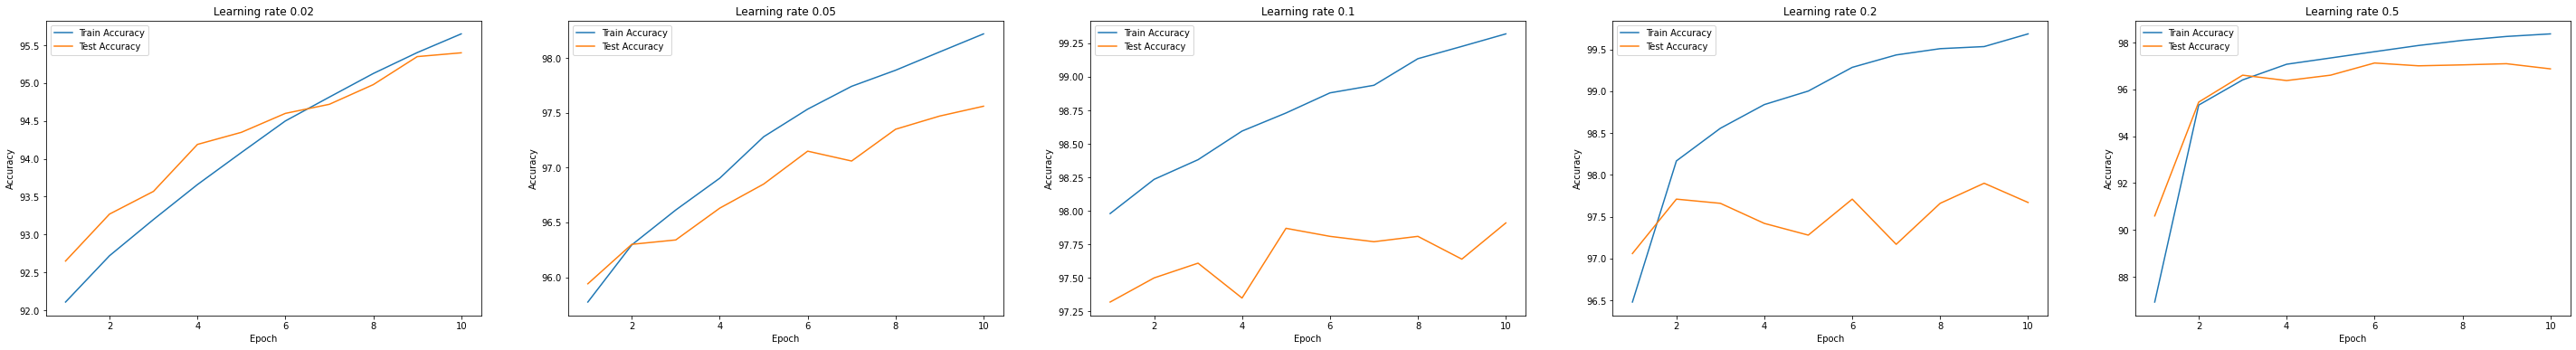

In [ ]:
#plot accuracy

i = 1
fig = plt.figure(figsize=(50, 6))
for learning_rate in alls:
    plt.subplot(1, 5, i)
    plt.plot(np.arange(1, 11, 1), alls[learning_rate]['train_acc'], label='Train Accuracy')
    plt.plot(np.arange(1, 11, 1), alls[learning_rate]['test_acc'], label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    # plt.ylim([0, 0.3])
    plt.title(f'Learning rate {learning_rate}')
    plt.legend()
    i += 1

#Vanishing Gradient

In this section, we want to see the vanishing gradient problem.

Create two separate models with 5 hidden layers of size [100, 100, 80, 50, 30],
one of them uses ReLU as an activation function and the other one uses Sigmoid.


In [ ]:
class MLP_relu(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 80)
        self.fc4 = nn.Linear(80, 50)
        self.fc5 = nn.Linear(50, 30)
        self.fc6 = nn.Linear(30, 10) # 10 classes

    def forward (self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.fc6(x)

        return x

In [ ]:
class MLP_sigmoid(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 80)
        self.fc4 = nn.Linear(80, 50)
        self.fc5 = nn.Linear(50, 30)
        self.fc6 = nn.Linear(30, 10) # 10 classes

    def forward (self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        x = torch.sigmoid(self.fc5(x))
        x = self.fc6(x)

        return x


In [ ]:
#instantiate the models

model_relu = MLP_relu()
model_sigmoid = MLP_sigmoid()
model_relu

MLP_relu(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=80, bias=True)
  (fc4): Linear(in_features=80, out_features=50, bias=True)
  (fc5): Linear(in_features=50, out_features=30, bias=True)
  (fc6): Linear(in_features=30, out_features=10, bias=True)
)

Modify the train function to save the gradient and weights of each layer, every epoch. Return these values as well.

In [ ]:
def train(model, loss_function, optimizer, train_loader, test_loader, epochs):

    train_losses = []
    test_losses = []
    train_acc = []
    test_acc = []
    weights = {'H1':[], 'H2':[], 'H3':[],'H4':[], 'H5':[]}
    biases = {'H1':[], 'H2':[], 'H3':[],'H4':[], 'H5':[]}
    grads = {'H1':[], 'H2':[], 'H3':[],'H4':[], 'H5':[]}

    # Set the model to train mode
    model.train()

    # Training loop
    epochs = tqdm(range(epochs))

    for epoch in epochs:

        batch_train_losses = []
        batch_train_acc = []

        model.train()
        for batch in train_loader:

            correct = 0 # Correct prediction per batch

            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            images = batch[0].reshape(-1, 28*28).to(device)
            labels = batch[1].to(device)

            ## Step 2: Run the model on the input data
            preds = model(images)
            preds = preds.squeeze(-1)

            ## Step 3: Calculate the loss
            loss = loss_function(preds, labels)

            ## Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()

            # Perform backpropagation
            loss.backward()

            ## Step 5: Update the parameters
            optimizer.step()

            # Train loss of each batch
            batch_train_losses.append(loss.item())

            # Train accuracy of each batch
            _, predicted = torch.max(preds, 1)
            correct += (predicted == labels).sum().item()
            accuracy = (correct / batch_size) * 100
            batch_train_acc.append(accuracy)


        # Retrieve the weight and biases of each hidden layer per epoch
        # our model.parameters is going to have 10 items for hidden layers and 2 items for output layer
        model_parameters = list(model.parameters())

        weights['H1'].append(model_parameters[0].tolist())
        weights['H2'].append(model_parameters[2].tolist())
        weights['H3'].append(model_parameters[4].tolist())
        weights['H4'].append(model_parameters[6].tolist())
        weights['H5'].append(model_parameters[8].tolist())

        biases['H1'].append(model_parameters[1].tolist())
        biases['H2'].append(model_parameters[3].tolist())
        biases['H3'].append(model_parameters[4].tolist())
        biases['H4'].append(model_parameters[5].tolist())
        biases['H5'].append(model_parameters[6].tolist())

        grads['H1'].append(model.fc1.weight.grad.tolist())
        grads['H2'].append(model.fc2.weight.grad.tolist())
        grads['H3'].append(model.fc3.weight.grad.tolist())
        grads['H4'].append(model.fc4.weight.grad.tolist())
        grads['H5'].append(model.fc5.weight.grad.tolist())


        # Computing test accuracy and test loss for each epoch
        test_losses, test_acc = eval_model(model, test_loader, test_losses, test_acc)

        # Computing train accuracy and train loss for each epoch
        train_losses.append(np.mean(batch_train_losses))
        train_acc.append(np.mean(batch_train_acc))
        epochs.set_postfix({'loss': train_losses})

    return train_losses, train_acc, test_acc, test_losses, weights, grads, biases

Now, train the sigmoid and relu model.

In [ ]:
#initialize loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer_relu = torch.optim.SGD(model_relu.parameters(), lr=0.01)
optimizer_sigmoid = torch.optim.SGD(model_sigmoid.parameters(), lr=0.01)

In [ ]:
model_relu.to(device)
model_sigmoid.to(device)

MLP_sigmoid(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=80, bias=True)
  (fc4): Linear(in_features=80, out_features=50, bias=True)
  (fc5): Linear(in_features=50, out_features=30, bias=True)
  (fc6): Linear(in_features=30, out_features=10, bias=True)
)

In [ ]:
# training ReLU
train_losses_relu, train_acc_relu, test_acc_relu, test_losses_relu, weights_relu, grads_relu, biases_relu = train(model_relu, loss_function, optimizer_relu, train_loader, test_loader, epochs)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# training Sigmoid
train_losses_sigmoid, train_acc_sigmoid, test_acc_sigmoid, test_losses_sigmoid, weights_sigmoid, grads_sigmoid, biases_sigmoid = train(model_sigmoid, loss_function, optimizer_sigmoid, train_loader, test_loader, epochs)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
print(len(grads_sigmoid['H1'][0]))
grads_sigmoid['H1'][0][0]

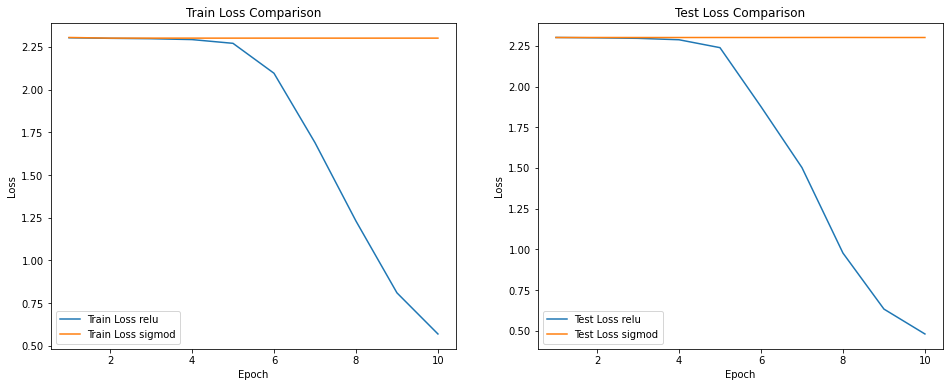

In [ ]:
#plot loss

fig = plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(np.arange(1, 11, 1), train_losses_relu, label='Train Loss relu')
plt.plot(np.arange(1, 11, 1), train_losses_sigmoid, label='Train Loss sigmod')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss Comparison')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(1, 11, 1), test_losses_relu, label='Test Loss relu')
plt.plot(np.arange(1, 11, 1), test_losses_sigmoid, label='Test Loss sigmod')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss Comparison')
plt.legend()

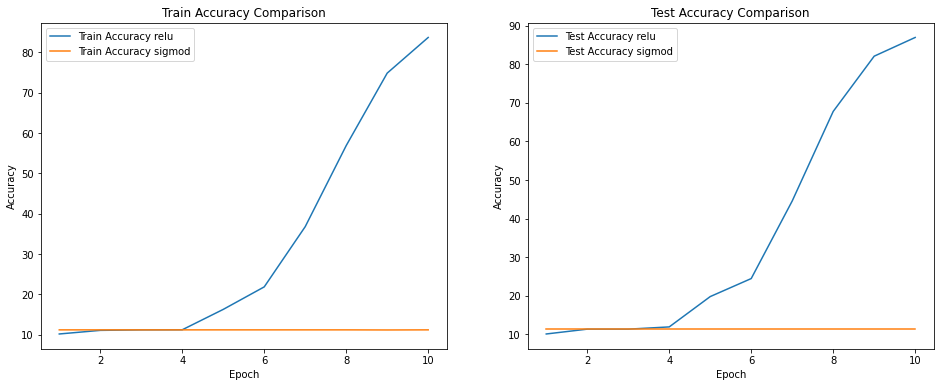

In [ ]:
#plot accuracy

fig = plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(np.arange(1, 11, 1), train_acc_relu, label='Train Accuracy relu')
plt.plot(np.arange(1, 11, 1), train_acc_sigmoid, label='Train Accuracy sigmod')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train Accuracy Comparison')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(1, 11, 1), test_acc_relu, label='Test Accuracy relu')
plt.plot(np.arange(1, 11, 1), test_acc_sigmoid, label='Test Accuracy sigmod')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Comparison')
plt.legend()

As you can see, the sigmoid model is not good at all. Based on the following plots explain why.



> As we can see because of large number of neurons and more layer than before we are facing vanishing gradient descent problem. In the plots that we draw in below there is almost no change in sigmoid weights because of the nature of its functionality. Also there is no significant change in the gradients of weights in sigmoid model and therefore there is no change in weights of this model and we don't learn anything and model not gonna change during epochs.

> But in contrast because of ReLU that isalmost a linear activation function somehow we manage vanishing gradient descent problem and we can reach to a better result.


For each layer, calculate the mean and std (standard deviation) of all its weights and plot these values ​​vs #epochs. Repeat the same for the grads.

You should do:

* Calculate the average weight of each hidden layer in each epoch.
* Calculate the std for the weight of each hidden layer in each epoch.

* Calculate the average grads of each hidden layer in each epoch.
* Calculate the std for the grads of each hidden layer in each epoch.

Plot all of them for both models (use subplot to compare two models' results).






In [ ]:
#calculate means and stds

# H1 -> 10 epoch * 100 hidden neurons * 784 input
# H2 -> 10 epoch * 100 hidden neurons * 100 hidden neurons from previous layer

# relu model
mean_weights_relu = {'H1':[], 'H2':[], 'H3':[], 'H4':[], 'H5':[]}
std_weights_relu = {'H1':[], 'H2':[], 'H3':[], 'H4':[], 'H5':[]}
mean_grads_relu = {'H1':[], 'H2':[], 'H3':[], 'H4':[], 'H5':[]}
std_grads_relu = {'H1':[], 'H2':[], 'H3':[], 'H4':[], 'H5':[]}

for hidden_layer in weights_relu:
    for epoch in weights_relu[hidden_layer]:
        flat_list = [num for neuron in epoch for num in neuron]
        mean_weights_relu[hidden_layer].append(statistics.mean(flat_list))
        std_weights_relu[hidden_layer].append(statistics.stdev(flat_list))

for hidden_layer in grads_relu:
    for epoch in grads_relu[hidden_layer]:
        flat_list = [num for neuron in epoch for num in neuron]
        mean_grads_relu[hidden_layer].append(statistics.mean(flat_list))
        std_grads_relu[hidden_layer].append(statistics.stdev(flat_list))

# sigmoid model
mean_weights_sigmoid = {'H1':[], 'H2':[], 'H3':[], 'H4':[], 'H5':[]}
std_weights_sigmoid = {'H1':[], 'H2':[], 'H3':[], 'H4':[], 'H5':[]}
mean_grads_sigmoid = {'H1':[], 'H2':[], 'H3':[], 'H4':[], 'H5':[]}
std_grads_sigmoid = {'H1':[], 'H2':[], 'H3':[], 'H4':[], 'H5':[]}

for hidden_layer in weights_sigmoid:
    for epoch in weights_sigmoid[hidden_layer]:
        flat_list = [num for neuron in epoch for num in neuron]
        mean_weights_sigmoid[hidden_layer].append(statistics.mean(flat_list))
        std_weights_sigmoid[hidden_layer].append(statistics.stdev(flat_list))

for hidden_layer in grads_sigmoid:
    for epoch in grads_sigmoid[hidden_layer]:
        flat_list = [num for neuron in epoch for num in neuron]
        mean_grads_sigmoid[hidden_layer].append(statistics.mean(flat_list))
        std_grads_sigmoid[hidden_layer].append(statistics.stdev(flat_list))


In [ ]:
# calculate average grads

# calculated at the above cell

In [ ]:
list(enumerate(mean_weights_relu))

[(0, 'H1'), (1, 'H2'), (2, 'H3'), (3, 'H4'), (4, 'H5')]

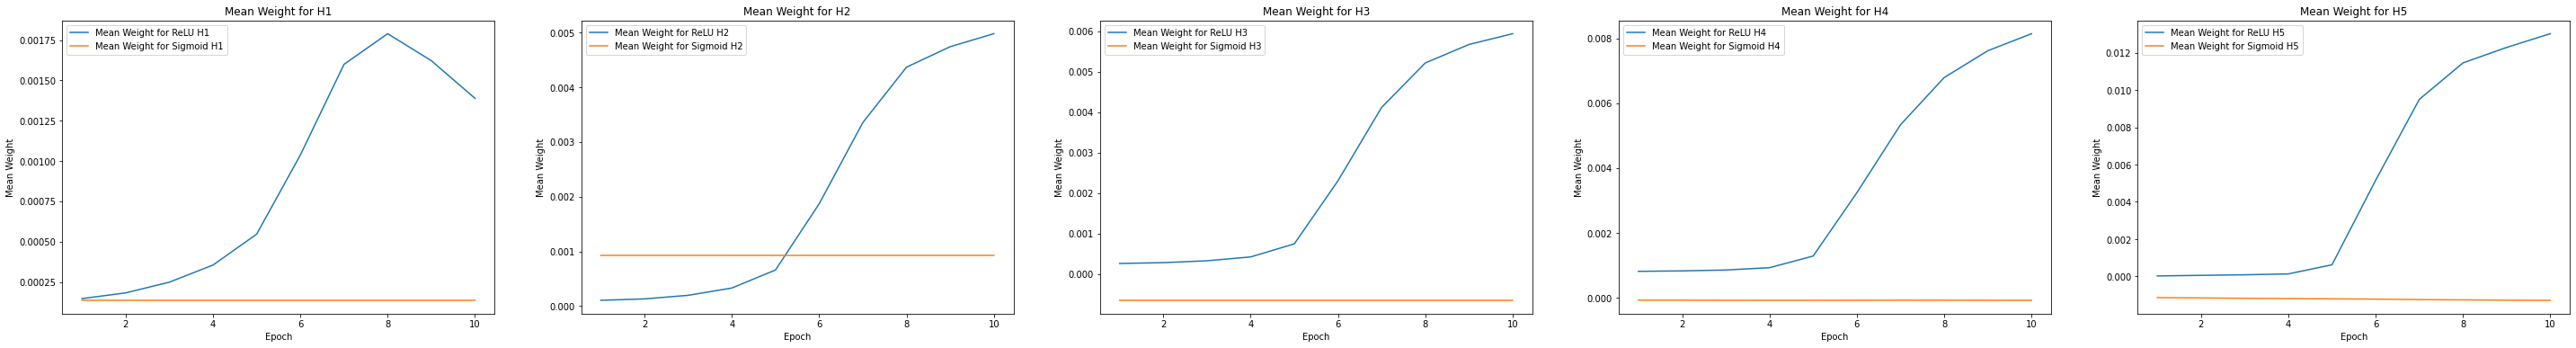

In [ ]:
#plot weights mean for the both models

# ReLU Model
fig = plt.figure(figsize=(50, 6))
axs = []

for index, hidden_layer in enumerate(mean_weights_relu):
    ax = plt.subplot(1, 5, index + 1)
    axs.append(ax)
    plt.plot(np.arange(1, 11, 1), mean_weights_relu[hidden_layer], label=f'Mean Weight for ReLU {hidden_layer}')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Weight')
    plt.title(f'Mean Weight for {hidden_layer}')

# Sigmoid Model
for index, hidden_layer in enumerate(mean_weights_sigmoid):
    axs[index].plot(np.arange(1, 11, 1), mean_weights_sigmoid[hidden_layer], label=f'Mean Weight for Sigmoid {hidden_layer}')
    axs[index].legend()


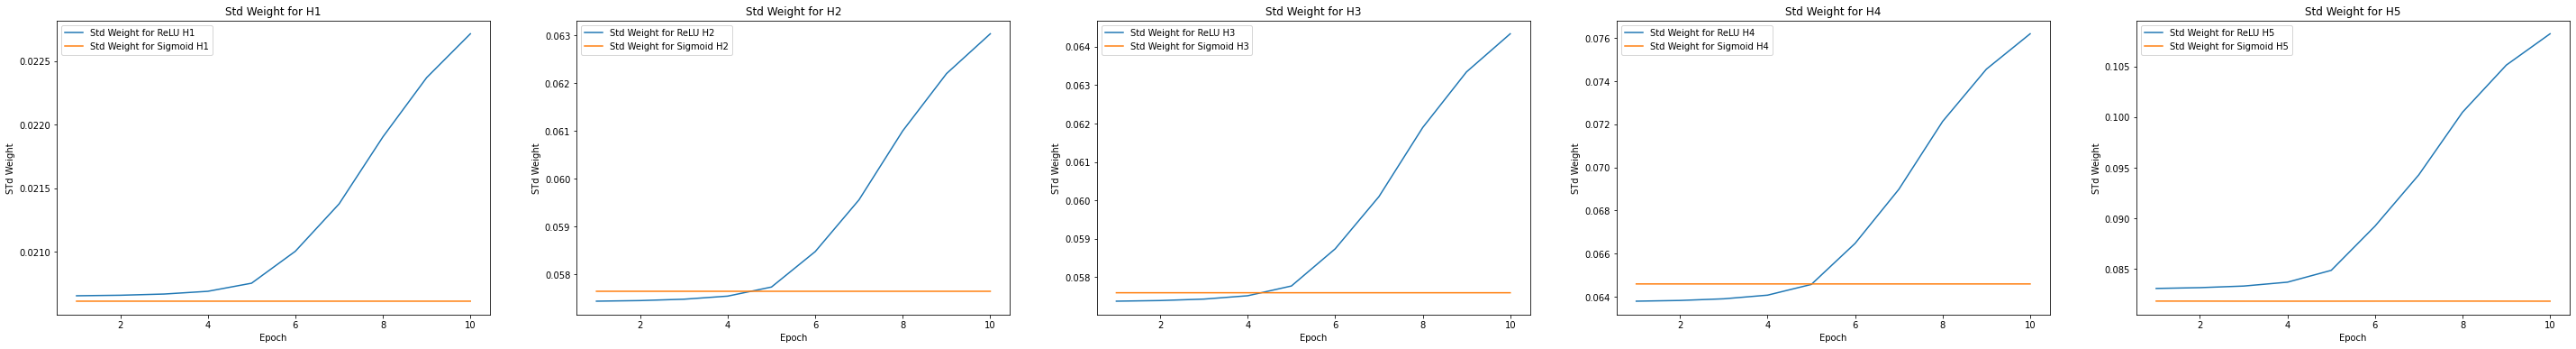

In [ ]:
#plot weights std for the both models

# ReLU Model
fig = plt.figure(figsize=(50, 6))
axs = []

for index, hidden_layer in enumerate(std_weights_relu):
    ax = plt.subplot(1, 5, index + 1)
    axs.append(ax)
    plt.plot(np.arange(1, 11, 1), std_weights_relu[hidden_layer], label=f'Std Weight for ReLU {hidden_layer}')
    plt.xlabel('Epoch')
    plt.ylabel('Std Weight')
    plt.title(f'Std Weight for {hidden_layer}')

# Sigmoid Model
for index, hidden_layer in enumerate(std_weights_sigmoid):
    axs[index].plot(np.arange(1, 11, 1), std_weights_sigmoid[hidden_layer], label=f'Std Weight for Sigmoid {hidden_layer}')
    axs[index].legend()


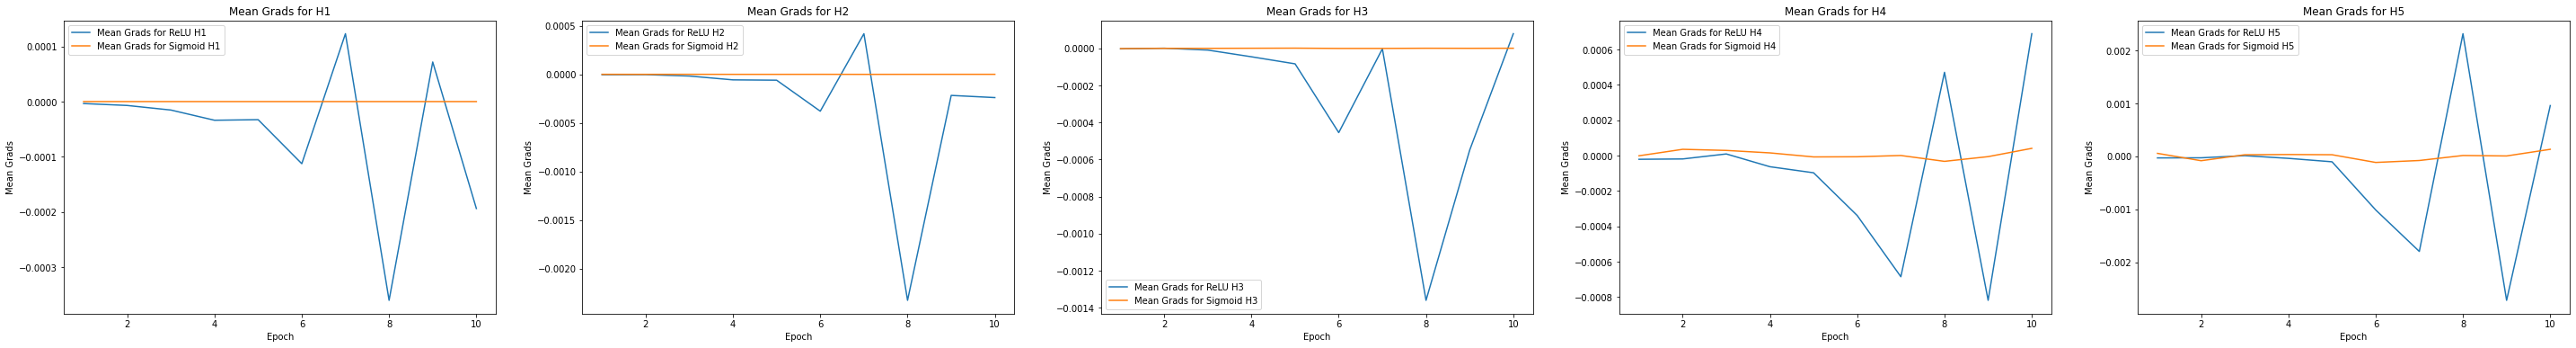

In [ ]:
#plot grads mean for the both models

# ReLU Model
fig = plt.figure(figsize=(50, 6))
axs = []

for index, hidden_layer in enumerate(mean_grads_relu):
    ax = plt.subplot(1, 5, index + 1)
    axs.append(ax)
    plt.plot(np.arange(1, 11, 1), mean_grads_relu[hidden_layer], label=f'Mean Grads for ReLU {hidden_layer}')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Grads')
    plt.title(f'Mean Grads for {hidden_layer}')

# Sigmoid Model
for index, hidden_layer in enumerate(mean_grads_sigmoid):
    axs[index].plot(np.arange(1, 11, 1), mean_grads_sigmoid[hidden_layer], label=f'Mean Grads for Sigmoid {hidden_layer}')
    axs[index].legend()


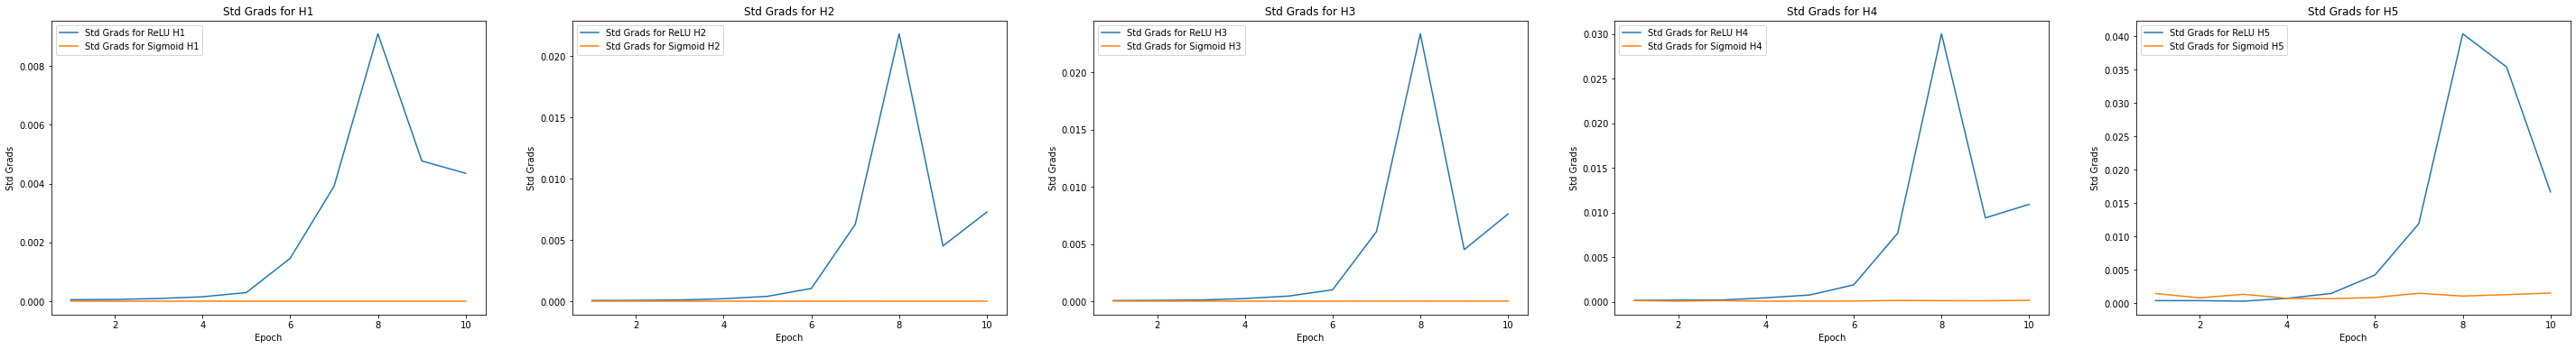

In [ ]:
#plot grads std for the both models

# ReLU Model
fig = plt.figure(figsize=(50, 6))
axs = []

for index, hidden_layer in enumerate(std_grads_relu):
    ax = plt.subplot(1, 5, index + 1)
    axs.append(ax)
    plt.plot(np.arange(1, 11, 1), std_grads_relu[hidden_layer], label=f'Std Grads for ReLU {hidden_layer}')
    plt.xlabel('Epoch')
    plt.ylabel('Std Grads')
    plt.title(f'Std Grads for {hidden_layer}')

# Sigmoid Model
for index, hidden_layer in enumerate(std_grads_sigmoid):
    axs[index].plot(np.arange(1, 11, 1), std_grads_sigmoid[hidden_layer], label=f'Std Grads for Sigmoid {hidden_layer}')
    axs[index].legend()


Good Luck!